In [6]:
import torchvision as tv
import torch
import torchvision.transforms as transforms
import torch.utils.data as data_utils

num_workers = 0
# how many samples per batch to load
batch_size = 20

transform = transforms.Compose([
    transforms.ToTensor(),
 ])  

trainset = tv.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
testset  = tv.datasets.MNIST(root='./data',  train=False, download=True, transform=transform)


indices = torch.arange(100)
train_loader_CLS = data_utils.Subset(trainset, indices)

train_loader = torch.utils.data.DataLoader(train_loader_CLS, batch_size=batch_size,shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(4 * 7 * 7, 12)  # FC layer to latent space

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

class ClassifierEncoder(nn.Module):
    def __init__(self):
        super(ClassifierEncoder, self).__init__()
        self.encoder = Encoder()
        self.fc1 = nn.Linear(12, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# initialize the NN
model = ClassifierEncoder().to(device)
print(model)

ClassifierEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Linear(in_features=196, out_features=12, bias=True)
  )
  (fc1): Linear(in_features=12, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)


In [14]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

Epoch [1/20], Train Loss: 2.3219, Train Accuracy: 11.00%, Test Loss: 2.3122, Test Accuracy: 10.10%
Epoch [2/20], Train Loss: 2.2849, Train Accuracy: 11.00%, Test Loss: 2.3002, Test Accuracy: 10.10%
Epoch [3/20], Train Loss: 2.2324, Train Accuracy: 11.00%, Test Loss: 2.2600, Test Accuracy: 18.04%
Epoch [4/20], Train Loss: 1.9934, Train Accuracy: 30.00%, Test Loss: 2.1246, Test Accuracy: 28.73%
Epoch [5/20], Train Loss: 1.6251, Train Accuracy: 48.00%, Test Loss: 1.8611, Test Accuracy: 38.69%
Epoch [6/20], Train Loss: 1.2573, Train Accuracy: 57.00%, Test Loss: 1.8208, Test Accuracy: 47.88%
Epoch [7/20], Train Loss: 0.8899, Train Accuracy: 69.00%, Test Loss: 2.0677, Test Accuracy: 51.00%
Epoch [8/20], Train Loss: 0.6094, Train Accuracy: 84.00%, Test Loss: 2.6414, Test Accuracy: 47.92%
Epoch [9/20], Train Loss: 0.5403, Train Accuracy: 76.00%, Test Loss: 2.3865, Test Accuracy: 51.45%
Epoch [10/20], Train Loss: 0.4464, Train Accuracy: 85.00%, Test Loss: 2.3831, Test Accuracy: 53.12%
Epoch [11

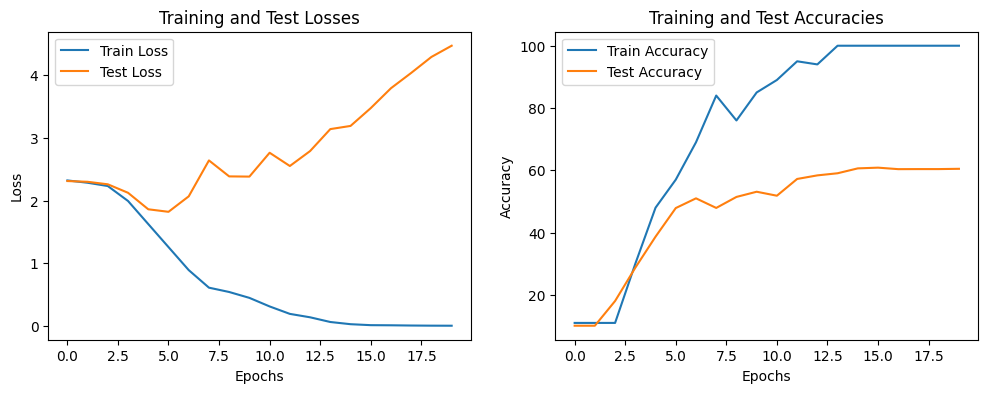

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracies')

plt.show()